In [10]:
import cv2 # OpenCV library for image processing
import pandas as pd # Pandas library for data manipulation
import os # OS library for file path operations
import matplotlib.pyplot as plt # Matplotlib for plotting images
import json # JSON library for reading JSON files

In [2]:
# ---- Configuration ----
TARGET_SIZE = 224 # Target size for resizing images
FACE_CASCADE_PATH = 'haarcascade_frontalface_default.xml' # Path to Haar Cascade for face detection
METADATA_FILE = 'metadata.json' # Path to metadata CSV file
DATA_ROOT = 'image_classification' # Root directory for image data
PADDING_FACTOR =  1.3 # Padding factor for face bounding box

In [3]:
# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(FACE_CASCADE_PATH)

In [4]:
def load_metadata(file_path):
    """Loads the list of dictionaries from the JSON file."""
    try:
        with open(file_path, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"ERROR: Metadata file not found at {file_path}. Returning empty list.")
        return []
    except json.JSONDecodeError:
        print(f"ERROR: Could not decode JSON file at {file_path}. Check file integrity.")
        return []

def save_metadata(data, file_path):
    """Saves the list of dictionaries back to the JSON file with indentation for readability."""
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=2)

print("JSON utility functions defined.")

JSON utility functions defined.


In [5]:
def process_image(item, face_cascade, data_root, target_size, padding_factor):
    """Processes a single image: detects face, crops, and resizes. 
       Updates the 'processing_status' key in the item dictionary."""
    
    # 1. Construct the full path
    input_path = os.path.join(data_root, item['path'])
    
    if not os.path.exists(input_path):
        item['processing_status'] = f"ERROR: File not found at {input_path}"
        return

    try:
        # 2. Read the image (OpenCV reads in BGR format)
        img = cv2.imread(input_path)
        if img is None:
            item['processing_status'] = "ERROR: Could not read image file."
            return
            
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 3. Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        
        if len(faces) == 0:
            item['processing_status'] = "SKIPPED: No face detected."
            return
        
        # 4. Use the largest detected face
        faces = sorted(faces, key=lambda f: f[2], reverse=True)
        (x, y, w, h) = faces[0]
        
        # 5. Apply Padding and calculate crop area
        center_x = x + w // 2
        center_y = y + h // 2
        crop_size = int(max(w, h) * padding_factor)
        
        x1 = max(0, center_x - crop_size // 2)
        y1 = max(0, center_y - crop_size // 2)
        x2 = min(img.shape[1], center_x + crop_size // 2)
        y2 = min(img.shape[0], center_y + crop_size // 2)
        
        # 6. Crop the image
        cropped_img = img[y1:y2, x1:x2]
        
        # 7. Resize to the target resolution
        resized_img = cv2.resize(cropped_img, (target_size, target_size), 
                                 interpolation=cv2.INTER_LINEAR)
        
        # 8. Save the processed image (overwriting the original)
        cv2.imwrite(input_path, resized_img)
        
        # 9. Update the status in the dictionary
        item['processing_status'] = "SUCCESS"

    except Exception as e:
        item['processing_status'] = f"ERROR: An exception occurred: {str(e)}"

print("Processing function updated for JSON list items.")

Processing function updated for JSON list items.


In [11]:
metadata_list = load_metadata(METADATA_FILE)

In [12]:
# 1. Load the metadata list
metadata_list = load_metadata(METADATA_FILE)

if not metadata_list:
    print("No metadata loaded. Exiting preprocessing.")
else:
    print(f"Loaded {len(metadata_list)} records. Starting image preprocessing...")

    # 2. Apply the processing function to every item in the list
    # We iterate and modify the dictionary items directly in the list
    for i, item in enumerate(metadata_list):
        # Optional: Print progress every 100 images
        if (i + 1) % 100 == 0:
            print(f"Processing image {i+1} of {len(metadata_list)}")
            
        process_image(item, face_cascade, DATA_ROOT, TARGET_SIZE, PADDING_FACTOR)

    # 3. Save the updated metadata list back to the JSON file
    save_metadata(metadata_list, METADATA_FILE)

    print("\n--- Processing Complete ---")
    print(f"All records processed and saved back to {METADATA_FILE}.")

Loaded 1 records. Starting image preprocessing...

--- Processing Complete ---
All records processed and saved back to metadata.json.


Processing Summary:
 processing_status
SUCCESS    1
Name: count, dtype: int64

Visual Verification (Showing first 5 SUCCESSFUL images):


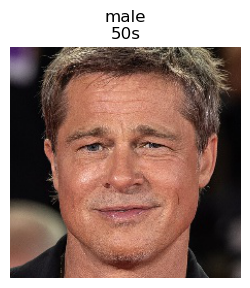

In [14]:
# Convert the final list of dictionaries to a Pandas DataFrame for easy analysis
# We use json_normalize to handle the nested 'attributes' object easily.
df = pd.json_normalize(metadata_list, sep='_')

if not df.empty:
    # 1. Print Summary
    summary = df['processing_status'].value_counts()
    print("Processing Summary:\n", summary)

    # 2. Check for skipped or failed images
    failed_df = df[df['processing_status'].str.startswith('ERROR') | 
                   df['processing_status'].str.startswith('SKIPPED')]
    
    if not failed_df.empty:
        print(f"\nFound {len(failed_df)} images that were skipped or had errors.")
        # Display the details of the first 5 failed images
        print(failed_df[['filename', 'path', 'processing_status']].head())
    
    # 3. Visual Verification (Showing first 5 SUCCESSFUL images)
    print("\nVisual Verification (Showing first 5 SUCCESSFUL images):")
    successful_df = df[df['processing_status'] == 'SUCCESS'].head(5)
    
    n = len(successful_df)
    if n == 0:
        print("No successful images to show.")
    else:
        fig, axes = plt.subplots(1, n, figsize=(15, 3))
        # Normalize `axes` to a list so we can index it uniformly
        if n == 1:
            axes = [axes]
        else:
            try:
                axes = axes.ravel()
            except Exception:
                axes = list(axes)

        for idx, (_, row) in enumerate(successful_df.iterrows()):
            img_path = os.path.join(DATA_ROOT, row['path'])
            img = cv2.imread(img_path)
            if img is None:
                axes[idx].text(0.5, 0.5, 'Could not read image', ha='center')
                axes[idx].axis('off')
                continue

            # Convert BGR to RGB for Matplotlib display
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[idx].imshow(img_rgb)
            # Assuming you have attributes_age_group from json_normalize
            age_group = row.get('attributes_age_group', 'N/A')
            axes[idx].set_title(f"{row.get('gender_label', 'N/A')}\n{age_group}")
            axes[idx].axis('off')
            
        plt.show()